# Setup

## Install

In [18]:
!pip install awswrangler
!pip install tensorflow

## Import

In [19]:
import pandas as pd
import awswrangler as wr
import boto3
import numpy as np
import matplotlib.pyplot as plt
from getpass import getpass
import os

In [20]:
import torch
import torch.nn as nn
from sklearn.preprocessing import MinMaxScaler
from torch.utils.data import DataLoader, Dataset

## Constants

In [21]:
# --- IMPORTANT: Set these variables before running ---
AWS_REGION = 'us-east-2'
S3_STAGING_DIR = 's3://cs230-market-data-2025/athena-query-results/'
ATHENA_DB = 'cs230_finance_data'
SQL_QUERY_NEWS = "SELECT * FROM fnspid_nasdaq_news_top5_summaries"
SQL_QUERY_STOCKS = "SELECT * FROM fnspid_stock_prices_top5"

INPUT_FEATURES = ['open', 'close', 'volume']
LEN_INPUT_FEATURES = 3
SEQ_LEN = 50
FUTURE_LEN = 3

NUM_CLASSES = 3


## Connect AWS

In [22]:
# --- AWS Authentication for Colab ---
# Prompt for AWS credentials
aws_access_key_id = getpass('Enter AWS Access Key ID: ')
aws_secret_access_key = getpass('Enter AWS Secret Access Key: ')


Enter AWS Access Key ID: ··········
Enter AWS Secret Access Key: ··········


# Preprocessing

## Read data from aws

In [23]:


print(f"\n--- Step 3: Configuration set for {ATHENA_DB} ---")
print(f"--- Step 4: Querying Data ---")
print(f"Querying data from {ATHENA_DB}....")

# Define df in a wider scope
df_news = None
df_stocks = None

try:
    # Create a boto3 session with the provided credentials
    session = boto3.Session(
        aws_access_key_id=aws_access_key_id,
        aws_secret_access_key=aws_secret_access_key,
        region_name=AWS_REGION,
    )

    # Run the query and load results into a Pandas DataFrame
    df_news = wr.athena.read_sql_query(
        sql=SQL_QUERY_NEWS,
        database=ATHENA_DB,
        s3_output=S3_STAGING_DIR,
        boto3_session=session,
    )

    df_stocks = wr.athena.read_sql_query(
        sql=SQL_QUERY_STOCKS,
        database=ATHENA_DB,
        s3_output=S3_STAGING_DIR,
        boto3_session=session,
    )
    SQL_QUERY_STOCKS

    print("\nQuery successful! Data loaded into DataFrame.")

    # Display the first 5 rows
    # df['bucket_distance'] = abs(df['bucket1'] - df['bucket2'])
    # conditions = [
    #   (df['bucket_distance'] <= 1),  # Class 0: Close
    #   ((df['bucket_distance'] >= 2) & (df['bucket_distance'] <= 3)), # Class 1: Medium
    #   (df['bucket_distance'] >= 4)  # Class 2: Far
    # ]
    # choices = [0, 1, 2]
    # df['bucket_dist_3_classes'] = np.select(conditions, choices, default=2).astype('int32')


except Exception as e:
    print(f"\nAn error occurred:")
    print(e)


--- Step 3: Configuration set for cs230_finance_data ---
--- Step 4: Querying Data ---
Querying data from cs230_finance_data....

Query successful! Data loaded into DataFrame.


## Process stock price data

In [24]:
df = df_stocks.copy()
df['date'] = pd.to_datetime(df['date']).dt.normalize()

In [25]:
# Helper function to create sequences
# INPUT_FEATURES = ['open', 'close', 'volume']
# SEQ_LEN = 50
# FUTURE_LEN = 3

def create_sequences(features, target, lookback=50, horizon=3):
    X, y = [], []
    # We create sequences of length 'lookback'
    # The target is 'horizon' steps after the sequence ends
    # Sequence ends at index i + lookback - 1
    # Target index is (i + lookback - 1) + horizon
    for i in range(len(features) - lookback - horizon + 1):
        X.append(features[i : i + lookback])
        y.append(target[i + lookback + horizon - 1])
    return np.array(X), np.array(y)

# Initialize containers
X_train_all, y_train_all = [], []
X_test_all, y_test_all = [], []
scalers = {}

# Get unique stock symbols
unique_symbols = df['stock_symbol'].unique()

print(f"Processing {len(unique_symbols)} stocks...")

for symbol in unique_symbols:
    # Filter and sort by date
    stock_data = df[df['stock_symbol'] == symbol].sort_values('date')

    # Select features
    features = stock_data[INPUT_FEATURES].values

    if len(features) == 0:
        continue

    # Split into train (80%) and test (20%)
    split_idx = int(len(features) * 0.8)
    train_features = features[:split_idx]
    test_features = features[split_idx:]

    # Scale features
    scaler = MinMaxScaler()
    # Fit on training data, transform both
    train_scaled = scaler.fit_transform(train_features)
    test_scaled = scaler.transform(test_features)

    # Store the scaler
    scalers[symbol] = scaler

    # Extract the target column ('close' is at index 1)
    train_target = train_scaled[:, 1]
    test_target = test_scaled[:, 1]

    # Create sequences
    X_tr, y_tr = create_sequences(train_scaled, train_target, lookback=SEQ_LEN, horizon=FUTURE_LEN)
    X_te, y_te = create_sequences(test_scaled, test_target, lookback=SEQ_LEN, horizon=FUTURE_LEN)

    # Append to lists if sequences were created
    if len(X_tr) > 0:
        X_train_all.append(X_tr)
        y_train_all.append(y_tr)
    if len(X_te) > 0:
        X_test_all.append(X_te)
        y_test_all.append(y_te)

# Concatenate all sequences
if X_train_all:
    X_train = np.concatenate(X_train_all, axis=0)
    y_train = np.concatenate(y_train_all, axis=0)
else:
    X_train, y_train = np.array([]), np.array([])

if X_test_all:
    X_test = np.concatenate(X_test_all, axis=0)
    y_test = np.concatenate(y_test_all, axis=0)
else:
    X_test, y_test = np.array([]), np.array([])

# Print final shapes
print("Data preparation complete.")
print(f"X_train shape: {X_train.shape}")
print(f"ç shape: {y_train.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"y_test shape: {y_test.shape}")

Processing 5 stocks...
Data preparation complete.
X_train shape: (30320, 50, 3)
ç shape: (30320,)
X_test shape: (7387, 50, 3)
y_test shape: (7387,)


## Prepare DataLoaders

In [26]:
import torch
from torch.utils.data import TensorDataset, DataLoader

# 1. Convert to PyTorch Tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32).unsqueeze(1)  # Reshape to (N, 1)

X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32).unsqueeze(1)    # Reshape to (N, 1)

# 2. Create TensorDatasets
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

# 3. Create DataLoaders
BATCH_SIZE = 64
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

# 4. Verify
print(f"Number of batches in train_loader: {len(train_loader)}")
print(f"Number of batches in test_loader: {len(test_loader)}")

# Check one batch
example_X, example_y = next(iter(train_loader))
print(f"Batch feature shape: {example_X.shape}")
print(f"Batch target shape: {example_y.shape}")

Number of batches in train_loader: 474
Number of batches in test_loader: 116
Batch feature shape: torch.Size([64, 50, 3])
Batch target shape: torch.Size([64, 1])


# Modeling

## Define Transformer Model


In [27]:
import torch
import torch.nn as nn
import math

class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=5000):
        super(PositionalEncoding, self).__init__()
        # Create a long enough P matrix
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))

        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)

        # Add batch dimension: (1, max_len, d_model)
        pe = pe.unsqueeze(0)
        self.register_buffer('pe', pe)

    def forward(self, x):
        # x shape: (batch, seq_len, d_model)
        # Slice pe to the current sequence length
        return x + self.pe[:, :x.size(1), :]

class TimeSeriesTransformer(nn.Module):
    def __init__(self, input_dim, d_model, num_heads, num_layers, output_dim, dropout=0.2, dim_feedforward=128):
        super(TimeSeriesTransformer, self).__init__()
        self.d_model = d_model

        # Input Projection
        self.input_projection = nn.Linear(input_dim, d_model)
        self.activation = nn.ReLU()

        # Positional Encoding
        self.pos_encoder = PositionalEncoding(d_model)
        self.pos_dropout = nn.Dropout(dropout)

        # Transformer Encoder
        # KEY FIX: norm_first=True (Pre-LN) usually stabilizes training significantly
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=d_model,
            nhead=num_heads,
            batch_first=True,
            dropout=dropout,
            dim_feedforward=dim_feedforward,
            norm_first=True # Pre-LayerNorm
        )
        self.transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)

        # Decoder / Output Layer
        self.decoder = nn.Linear(d_model, output_dim)

    def forward(self, x):
        # x shape: (batch, seq_len, input_dim)

        # 1. Project input and SCALE
        x = self.input_projection(x) * math.sqrt(self.d_model)
        x = self.activation(x)

        # 2. Add positional encodings and Dropout
        x = self.pos_encoder(x)
        x = self.pos_dropout(x)

        # 3. Pass through Transformer Encoder
        x = self.transformer_encoder(x)

        # 4. Select the output of the last time step
        x = x[:, -1, :]

        # 5. Final prediction
        x = self.decoder(x)
        return x

# Instantiate Model with Pre-Norm and Higher Dropout
input_dim = LEN_INPUT_FEATURES
d_model = 32
num_heads = 4
num_layers = 4
output_dim = 1
dim_feedforward = 128

# Increased dropout to 0.2 to combat overfitting
model_transformer = TimeSeriesTransformer(input_dim, d_model, num_heads, num_layers, output_dim, dropout=0.2, dim_feedforward=dim_feedforward)

# Move to Device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model_transformer = model_transformer.to(device)

print("Device:", device)
print(f"The model has {sum(p.numel() for p in model_transformer.parameters() if p.requires_grad):,} trainable parameters")

Device: cuda
The model has 50,977 trainable parameters


/usr/local/lib/python3.12/dist-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.norm_first was True
  warnings.warn(


## Train Model

### Subtask:
Train the initialized Transformer model for a fixed number of epochs using Adam optimizer and MSE loss, and visualize the learning curves.


**Reasoning**:
Implement the training loop for the Transformer model, including loss calculation, optimization, and validation, followed by plotting the training and test loss curves.



Starting training for 100 epochs on cuda with OneCycleLR...
Epoch [1/100] | LR: 0.000043 | Train Loss: 0.442964 | Test Loss: 2.586259
Epoch [2/100] | LR: 0.000050 | Train Loss: 0.048354 | Test Loss: 2.007323
Epoch [3/100] | LR: 0.000063 | Train Loss: 0.027649 | Test Loss: 1.772675
Epoch [4/100] | LR: 0.000082 | Train Loss: 0.018507 | Test Loss: 1.741558
Epoch [5/100] | LR: 0.000104 | Train Loss: 0.012784 | Test Loss: 1.569848
Epoch [6/100] | LR: 0.000132 | Train Loss: 0.009059 | Test Loss: 1.594870
Epoch [7/100] | LR: 0.000163 | Train Loss: 0.006527 | Test Loss: 1.620959
Epoch [8/100] | LR: 0.000199 | Train Loss: 0.004790 | Test Loss: 1.718530
Epoch [9/100] | LR: 0.000238 | Train Loss: 0.003474 | Test Loss: 1.699139
Epoch [10/100] | LR: 0.000280 | Train Loss: 0.002684 | Test Loss: 1.706625
Epoch [11/100] | LR: 0.000325 | Train Loss: 0.002075 | Test Loss: 1.805658
Epoch [12/100] | LR: 0.000372 | Train Loss: 0.001641 | Test Loss: 1.890622
Epoch [13/100] | LR: 0.000420 | Train Loss: 0.001

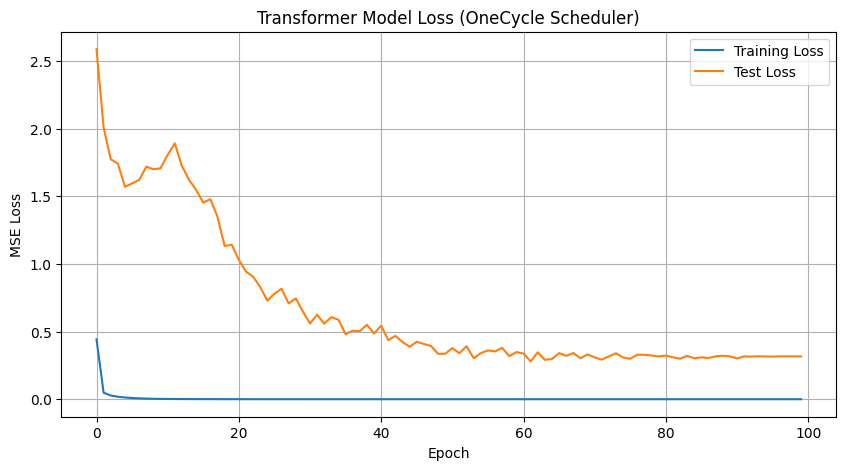

In [28]:
import torch.optim as optim
import matplotlib.pyplot as plt

criterion = nn.MSELoss()
# 1. Initialize Optimizer
# Start with a lower initial LR, let the scheduler handle the peak
optimizer = optim.AdamW(model_transformer.parameters(), lr=1e-3, weight_decay=1e-4)

# 2. Training Loop Configuration
num_epochs = 100
train_losses = []
test_losses = []

# 3. Scheduler (OneCycleLR)
# This handles both Warm-up and Decay automatically
total_steps = len(train_loader) * num_epochs
scheduler = optim.lr_scheduler.OneCycleLR(
    optimizer,
    max_lr=1e-3,              # Peak Learning Rate
    total_steps=total_steps,
    pct_start=0.3,            # Warm up for 30% of the time
    div_factor=25,            # Initial LR = max_lr / 25
    final_div_factor=1000     # Final LR = max_lr / (25 * 1000)
)

print(f"Starting training for {num_epochs} epochs on {device} with OneCycleLR...")

for epoch in range(num_epochs):
    # --- Training Phase ---
    model_transformer.train()
    running_train_loss = 0.0

    for X_batch, y_batch in train_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)

        optimizer.zero_grad()
        outputs = model_transformer(X_batch)
        loss = criterion(outputs, y_batch)
        loss.backward()

        # Gradient Clipping
        torch.nn.utils.clip_grad_norm_(model_transformer.parameters(), 1.0)

        optimizer.step()
        scheduler.step() # Update LR per batch

        running_train_loss += loss.item() * X_batch.size(0)

    epoch_train_loss = running_train_loss / len(train_loader.dataset)
    train_losses.append(epoch_train_loss)

    # --- Validation Phase ---
    model_transformer.eval()
    running_test_loss = 0.0
    with torch.no_grad():
        for X_batch, y_batch in test_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            outputs = model_transformer(X_batch)
            loss = criterion(outputs, y_batch)
            running_test_loss += loss.item() * X_batch.size(0)

    epoch_test_loss = running_test_loss / len(test_loader.dataset)
    test_losses.append(epoch_test_loss)

    current_lr = scheduler.get_last_lr()[0]
    print(f"Epoch [{epoch+1}/{num_epochs}] | LR: {current_lr:.6f} | Train Loss: {epoch_train_loss:.6f} | Test Loss: {epoch_test_loss:.6f}")

print("Training finished.")

# 3. Plot Loss Curves
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Training Loss')
plt.plot(test_losses, label='Test Loss')
plt.title('Transformer Model Loss (OneCycle Scheduler)')
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.legend()
plt.grid(True)
plt.show()

# Evaluate Model Metrics



Transformer Model Evaluation on Test Set:
Mean Squared Error (MSE): 0.316719
Mean Absolute Error (MAE): 0.336271
R2 Score: 0.874511


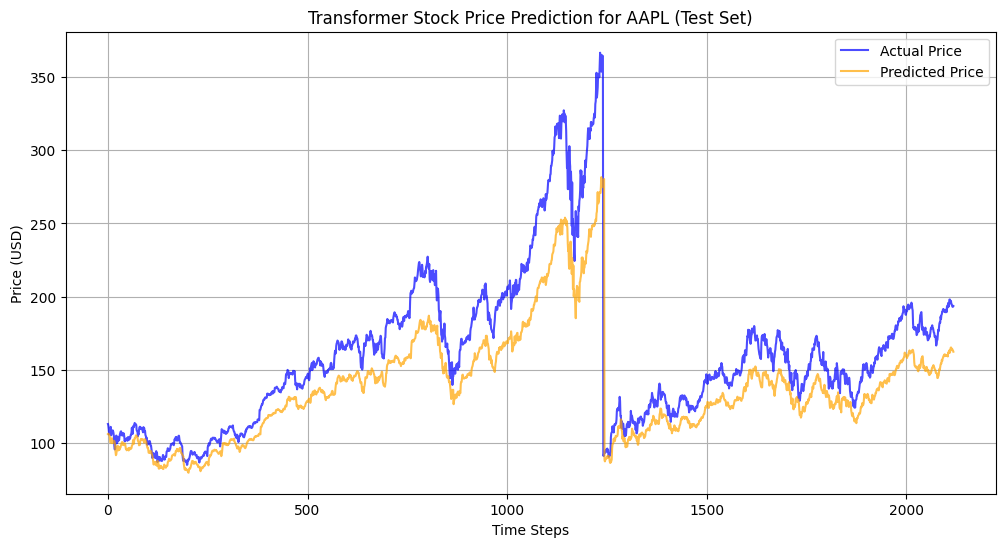

In [29]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt
import numpy as np

# 1. Select 'aapl' data
stock_symbol = 'aapl'
aapl_df = df[df['stock_symbol'] == stock_symbol].sort_values('date')
features_aapl = aapl_df[INPUT_FEATURES].values

# 2. Identify split index
split_idx = int(len(features_aapl) * 0.8)
test_features_aapl = features_aapl[split_idx:]

# 3. Scale using the pre-fitted scaler
scaler_aapl = scalers[stock_symbol]
test_scaled_aapl = scaler_aapl.transform(test_features_aapl)

# 4. Generate sequences
# Target 'close' is at index 1
test_target_aapl = test_scaled_aapl[:, 1]
X_test_aapl, y_test_aapl = create_sequences(test_scaled_aapl, test_target_aapl, lookback=SEQ_LEN, horizon=FUTURE_LEN)


# 1. Set model to evaluation mode
model_transformer.eval()

# 2. Generate predictions on the entire test set
with torch.no_grad():
    test_input = X_test_tensor.to(device)
    test_predictions = model_transformer(test_input).cpu().numpy()

# 3. Calculate Metrics
flattened_predictions = test_predictions.flatten()
mse = mean_squared_error(y_test, flattened_predictions)
mae = mean_absolute_error(y_test, flattened_predictions)
r2 = r2_score(y_test, flattened_predictions)

print("Transformer Model Evaluation on Test Set:")
print(f"Mean Squared Error (MSE): {mse:.6f}")
print(f"Mean Absolute Error (MAE): {mae:.6f}")
print(f"R2 Score: {r2:.6f}")

# 4. Visualization for AAPL
# Reuse the AAPL test data prepared earlier: X_test_tensor_aapl
# Ensure it is on the correct device
X_test_tensor_aapl = torch.tensor(X_test_aapl, dtype=torch.float32).to(device)

with torch.no_grad():
    predictions_aapl = model_transformer(X_test_tensor_aapl).cpu().numpy()

# Inverse Transform
pred_extended = np.zeros((len(predictions_aapl), 3))
actual_extended = np.zeros((len(y_test_aapl), 3))
pred_extended[:, 1] = predictions_aapl.flatten()
actual_extended[:, 1] = y_test_aapl

scaler_aapl = scalers['aapl'] # Ensure we use the correct scaler
inverse_pred = scaler_aapl.inverse_transform(pred_extended)[:, 1]
inverse_actual = scaler_aapl.inverse_transform(actual_extended)[:, 1]

# Plot
plt.figure(figsize=(12, 6))
plt.plot(inverse_actual, label='Actual Price', color='blue', alpha=0.7)
plt.plot(inverse_pred, label='Predicted Price', color='orange', alpha=0.7)
plt.title(f'Transformer Stock Price Prediction for AAPL (Test Set)')
plt.xlabel('Time Steps')
plt.ylabel('Price (USD)')
plt.legend()
plt.grid(True)
plt.show()